In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import shap

In [101]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


In [104]:
import os
os.makedirs('outputs', exist_ok=True)
df = pd.read_csv('archive/loan_approval_dataset.csv')
df.columns = df.columns.str.strip()
print("✅ Dataset loaded. Shape:", df.shape)

✅ Dataset loaded. Shape: (4269, 13)


# CLEANING DATA

In [108]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)

df = df.drop_duplicates()
print(f"✅ Cleaning done. Shape: {df.shape}")

✅ Cleaning done. Shape: (4269, 13)


In [109]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

outlier_cols = ['income_annum', 'loan_amount', 'cibil_score']
for col in outlier_cols:
    if col in df.columns:
        original = len(df)
        df = remove_outliers_iqr(df, col)
        print(f"Removed {original - len(df)} outliers from {col}")

df = df.reset_index(drop=True)

Removed 0 outliers from income_annum
Removed 0 outliers from loan_amount
Removed 0 outliers from cibil_score


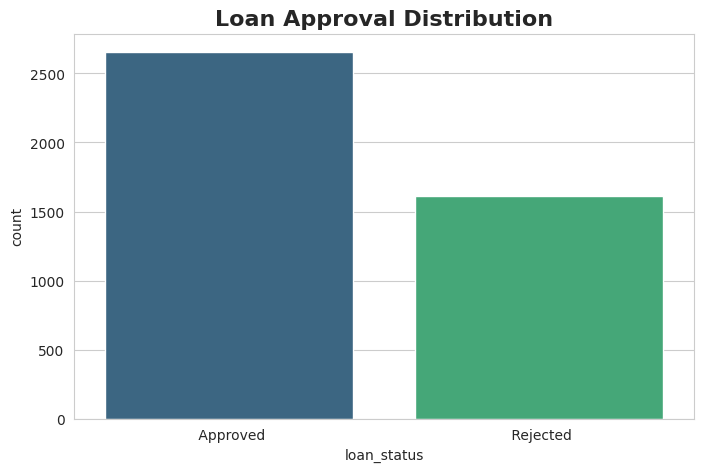

In [110]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='loan_status', palette='viridis')
plt.title('Loan Approval Distribution', fontsize=16, fontweight='bold')
plt.savefig('outputs/target_distribution.png', dpi=300)
plt.show()


In [ ]:
df['debt_to_income'] = df['loan_amount'] / (df['income_annum'] + 1)
df['cibil_category'] = pd.cut(df['cibil_score'], [0, 500, 650, 750, 900], labels=['Poor', 'Fair', 'Good', 'Excellent'])

* critical fix


In [113]:
df['loan_status'] = df['loan_status'].map({' Approved': 1, ' Rejected':0}).astype(int)
print("Target fixed! Values:", df['loan_status'].unique())

Target fixed! Values: [1 0]


In [114]:
for col in  ['education', 'self_employed', 'cibil_category']:
    if col in df.columns:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# TRAIN TEST SPLIT

In [115]:
X = df.drop(['loan_status', 'loan_id'], axis=1)
y = df['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_text_scaled = scaler.transform(X_test)

print("processing done")

processing done


* model training

In [116]:
models = {
    "Logistic": LogisticRegression(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(n_estimatros=100, random_state=42)
}

In [117]:
result = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train_bal)
    y_proba = model.predict_proba(X_text_scaled)[:, 1]
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"{name} ROC-AUC: {roc_auc:.4f}")
    result[name] = {'model': model, 'proba': y_proba, 'roc_auc': roc_auc}

best_model_name = max(result, key=lambda x: result[x]['roc_auc'])
best_model = result[best_model_name]['model']
print(f"\n Best: {best_model_name}({result[best_model_name]['roc_auc']:.4f})")


Training Logistic...
Logistic ROC-AUC: 0.9737

Training Random Forest...
Random Forest ROC-AUC: 0.9993

Training XGBoost...
XGBoost ROC-AUC: 0.9997

 Best: XGBoost(0.9997)


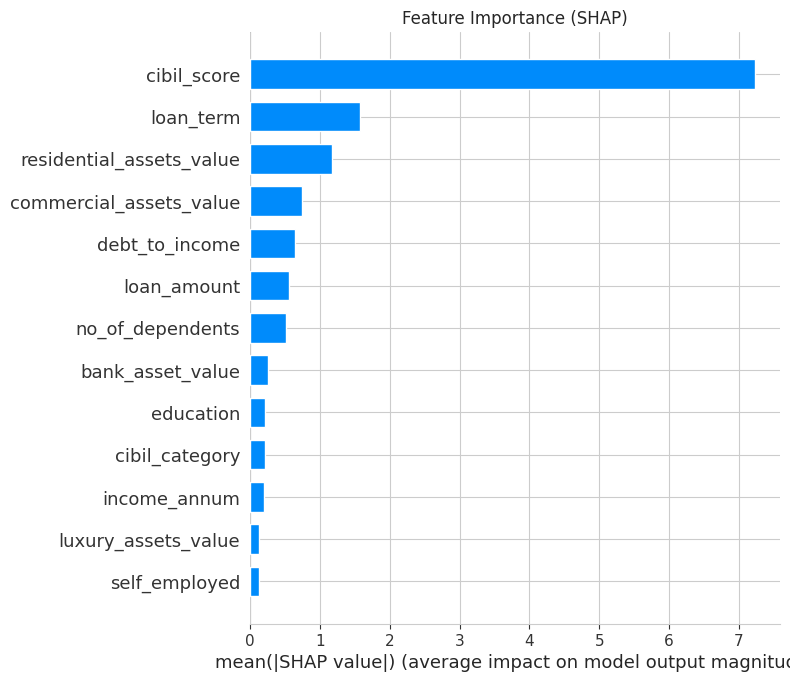

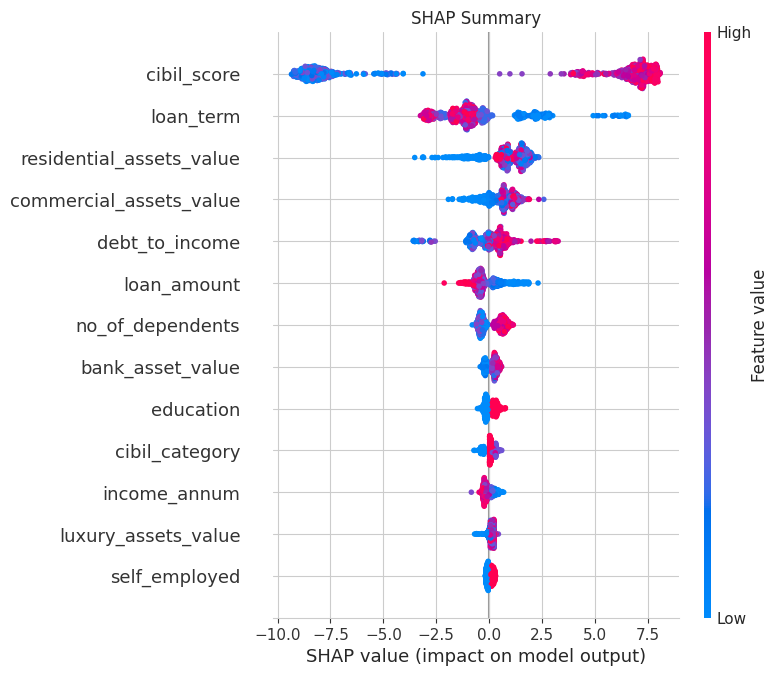

Top features: Index(['cibil_score', 'loan_term', 'residential_assets_value',
       'commercial_assets_value', 'debt_to_income'],
      dtype='object')


In [120]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_scaled)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_scaled, X.columns, plot_type='bar', show=False)
plt.title('Feature Importance (SHAP)')
plt.savefig('outputs/shap_importance.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_scaled, X.columns, show=False)
plt.title('SHAP Summary')
plt.savefig('outputs/shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("Top features:", X.columns[np.argsort(np.abs(shap_values).mean(0))[-5:]][::-1])
